- 아래 링크의 clustering 관련 코드 기반으로 수정 및 추가
    - https://dacon.io/competitions/official/235736/codeshare/2844?page=1&dtype=recent

In [114]:
''' import '''
import os
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

plt.rc('font', family='Malgun Gothic') # For Windows
# print(plt.rcParams['font.family'])
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import FinanceDataReader as fdr

from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler


' import '

In [115]:
def merge_lists(fracs):
    tot = []
    for frac in fracs:
        tot.extend(frac)
    return tot


''' to signal function '''
def to_signal(_type, n, shift):
    def to_sin(x):
        return np.sin((x-shift)*2*np.pi/n)
    def to_cos(x):
        return np.cos((x-shift)*2*np.pi/n)
    
    if _type == 'sin':
        return to_sin
    else:
        return to_cos


' to signal function '

In [127]:
''' get bnums '''
b_public = [17, 18, 19, 20, 21, 22, 23] # + [53, 55, 59, 60] + [69, 70, 74]  # 16
b_uni = [24, 25, 26, 27, 28, 29, 31] # + [72] # 30
b_dcenter = [32, 33, 34, 35, 36]  #
b_dstore = [37, 38, 39, 40, 41, 42]  # 43, 44
b_medic = [45, 46, 47, 48, 49, 50, 51, 52] # + [56, 58] + [73, 76]  #
b_comm = [53, 55, 56, 57, 58, 59, 60]  # 54
b_apart = [61, 62, 63, 64, 65, 66, 67, 68]  #
b_lab = [69, 70, 72, 74, 76]  # 71, 73, 75
b_biz = [77, 78, 79, 80, 82, 83, 84]  # 81
b_mart = [6, 9] + [86, 87, 88, 89, 90, 91, 92]  # 85
b_hotel = [11] + [93, 94, 96, 97, 98, 99, 100]  # 95
others = [1] + [2, 4, 7, 12, 75, 85, 95] + [14, 15, 30, 71, 73] + [43, 44, 81]  # [8, 10, 13] + 
total = [b_public, b_uni, b_dcenter, b_dstore, b_medic, b_comm, b_apart, b_lab, b_biz, b_mart, b_hotel, others]
excludes = merge_lists(total)
bnums = list(set(range(1, 101)) - set(excludes))

' get bnums '

In [144]:
args = {
    'buildings': bnums,
    'outliers': True,
}

In [145]:
# data load // get specific buildings // drop 일조 & 일사 & 강수량 & 태양광 & ESS & PCS // merge df_building // datehour process // wind & humidity interpolate
''' data load '''
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')
train = df_train.copy()
test = df_test.copy()
df_building = pd.read_csv('../data/building_info.csv')

''' merge df_building'''
train = train.merge(df_building, on='건물번호')
test = test.merge(df_building, on='건물번호')

''' date hour process '''
train['datehour'] = pd.to_datetime(train['일시'].str.replace(' ', ''), format='%Y%m%d%H')
test['datehour'] = pd.to_datetime(test['일시'].str.replace(' ', ''), format='%Y%m%d%H')
train['date'] = pd.to_datetime(train['일시'].str.slice(0, 8), format='%Y%m%d')
test['date'] = pd.to_datetime(test['일시'].str.slice(0, 8), format='%Y%m%d')
train = train.drop(['일시', 'num_date_time'], axis=1)
test = test.drop(['일시', 'num_date_time'], axis=1)

''' wind / humidity interpolate '''
train['습도(%)'] = train['습도(%)'].interpolate().round(1)
train['풍속(m/s)'] = train['풍속(m/s)'].interpolate().round(1)

''' get specific buildings '''
train = train.loc[train['건물번호'].isin(args['buildings'])].sort_values(['건물번호', 'datehour']).reset_index(drop=True)
test = test.loc[test['건물번호'].isin(args['buildings'])].sort_values(['건물번호', 'datehour']).reset_index(drop=True)

''' drop 일조 & 일사 & 강수량 & 태양광 & ESS & PCS '''
train = train.drop(['일조(hr)', '일사(MJ/m2)', '강수량(mm)', '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)'], axis=1)
test = test.drop(['강수량(mm)', '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)'], axis=1)

' data load '

' merge df_building'

' date hour process '

' wind / humidity interpolate '

' get specific buildings '

' drop 일조 & 일사 & 강수량 & 태양광 & ESS & PCS '

In [146]:
# object -> category
if True:
    ''' object -> category '''
    type_to = 'category'
    feats = ['건물번호', '건물유형', 'hour', 'holiday', 'dayofweek']
    for feat in feats:
        train[feat] = train[feat].astype(type_to)
        test[feat] = test[feat].astype(type_to)

' Preprocess '

' hour '

' dayofweek '

' holiday '

' humidex : (5/9 * 섭씨온도) - { 0.55 * (1 - 상대습도(%)) * (5/9 * 섭씨온도 - 26) } + 32 '

' object -> category '

In [147]:
# outliers
if args['outliers']:
    ''' outlliers '''
    # 기타 건물
    if 4 in args['buildings']:
        train.loc[(train['건물번호'] == 4) & (train['datehour'] >= '2022-07-25-22') & (train['datehour'] <= '2022-07-25-22'), '전력소비량(kWh)'] = 620
    if 11 in args['buildings']:
        train.loc[(train['건물번호'] == 11) & (train['datehour'] > '2022-07-22') & (train['datehour'] < '2022-08-18') & (train['전력소비량(kWh)'] < 1490), '전력소비량(kWh)'] = [1680.13, 1662.54, 1662.54, 1693.95, 2328.63, 1871.64]
        # train.loc[(train['건물번호'] == 11) & (train['datehour'] >= '2022-07-01')].groupby('hour')['전력소비량(kWh)'].mean()

    # public
    if 16 in args['buildings']:
        train.loc[(train['건물번호'] == 16) & (train['datehour'] >= '2022-06-22-01') & (train['datehour'] < '2022-06-22-02'), '전력소비량(kWh)'] =\
        (train.loc[(train['건물번호'] == 16) & (train['datehour'] >= '2022-06-22-00') & (train['datehour'] < '2022-06-22-01'), '전력소비량(kWh)'].values +\
            train.loc[(train['건물번호'] == 16) & (train['datehour'] >= '2022-06-22-02') & (train['datehour'] < '2022-06-22-03'), '전력소비량(kWh)'].values) / 2
    if 17 in args['buildings']:
        train.loc[(train['건물번호'] == 17) & (train['datehour'] >= '2022-06-18') & (train['datehour'] < '2022-06-19'), '전력소비량(kWh)'] =\
        (train.loc[(train['건물번호'] == 17) & (train['datehour'] >= '2022-06-11') & (train['datehour'] < '2022-06-12'), '전력소비량(kWh)'].values +\
            train.loc[(train['건물번호'] == 17) & (train['datehour'] >= '2022-06-25') & (train['datehour'] < '2022-06-26'), '전력소비량(kWh)'].values) / 2
        train.loc[(train['건물번호'] == 17) & (train['datehour'] >= '2022-07-23') & (train['datehour'] < '2022-07-24'), '전력소비량(kWh)'] =\
            train.loc[(train['건물번호'] == 17) & (train['dayofweek'] == 5)].groupby('hour')['전력소비량(kWh)'].mean().values
    if 22 in args['buildings']:
        train.loc[(train['건물번호'] == 22) & (train['datehour'] >= '2022-06-22') & (train['datehour'] < '2022-06-23'), '전력소비량(kWh)'] =\
        (train.loc[(train['건물번호'] == 22) & (train['datehour'] >= '2022-06-15') & (train['datehour'] < '2022-06-16'), '전력소비량(kWh)'].values +\
            train.loc[(train['건물번호'] == 22) & (train['datehour'] >= '2022-06-29') & (train['datehour'] < '2022-06-30'), '전력소비량(kWh)'].values) / 2
    if 23 in args['buildings']:
        train.loc[(train['건물번호'] == 23) & (train['datehour'] >= '2022-07-04-20') & (train['datehour'] < '2022-07-05-06'), '전력소비량(kWh)'] =\
        (train.loc[(train['건물번호'] == 23) & (train['datehour'] >= '2022-06-27-20') & (train['datehour'] < '2022-06-28-06'), '전력소비량(kWh)'].values +\
            train.loc[(train['건물번호'] == 23) & (train['datehour'] >= '2022-07-11-20') & (train['datehour'] < '2022-07-12-06'), '전력소비량(kWh)'].values) / 2

    # uni
    if 26 in args['buildings']:
        train.loc[(train['건물번호'] == 26) & (train['datehour'] >= '2022-07-16') & (train['datehour'] < '2022-07-18'), '전력소비량(kWh)'] =\
        (train.loc[(train['건물번호'] == 26) & (train['datehour'] >= '2022-07-23') & (train['datehour'] < '2022-07-25'), '전력소비량(kWh)'].values +\
            train.loc[(train['건물번호'] == 26) & (train['datehour'] >= '2022-07-09') & (train['datehour'] < '2022-07-11'), '전력소비량(kWh)'].values) / 2
    if 28 in args['buildings']:
        train.loc[(train['건물번호'] == 28) & (train['datehour'] >= '2022-07-28-02') & (train['datehour'] < '2022-07-28-03'), '전력소비량(kWh)'] =\
            (train.loc[(train['건물번호'] == 28) & (train['datehour'] >= '2022-07-28-01') & (train['datehour'] < '2022-07-28-02'), '전력소비량(kWh)'].values +\
                train.loc[(train['건물번호'] == 28) & (train['datehour'] >= '2022-07-28-03') & (train['datehour'] < '2022-07-28-04'), '전력소비량(kWh)'].values) / 2
    if 29 in args['buildings']:
        train.loc[(train['건물번호'] == 29) & (train['datehour'] >= '2022-06-25-12') & (train['datehour'] < '2022-06-25-16'), '전력소비량(kWh)'] =\
            train.loc[(train['건물번호'] == 29) & (train['datehour'] >= '2022-06-25-12') & (train['datehour'] < '2022-06-25-16'), '전력소비량(kWh)'] + 55
        train.loc[(train['건물번호'] == 29) & (train['datehour'] >= '2022-06-25-14') & (train['datehour'] < '2022-06-25-16'), '전력소비량(kWh)'] =\
            train.loc[(train['건물번호'] == 29) & (train['datehour'] >= '2022-06-25-14') & (train['datehour'] < '2022-06-25-16'), '전력소비량(kWh)'] + 120
        train.loc[(train['건물번호'] == 29) & (train['datehour'] >= '2022-08-20-12') & (train['datehour'] < '2022-08-20-15'), '전력소비량(kWh)'] =\
            train.loc[(train['건물번호'] == 29) & (train['datehour'] >= '2022-08-20-12') & (train['datehour'] < '2022-08-20-15'), '전력소비량(kWh)'] + 130
    if 31 in args['buildings']:
        train.loc[(train['건물번호'] == 31) & (train['datehour'] >= '2022-07-02-11') & (train['datehour'] < '2022-07-02-12'), '전력소비량(kWh)'] =\
            (train.loc[(train['건물번호'] == 31) & (train['datehour'] >= '2022-07-02-10') & (train['datehour'] < '2022-07-02-11'), '전력소비량(kWh)'] +\
                train.loc[(train['건물번호'] == 31) & (train['datehour'] >= '2022-07-02-12') & (train['datehour'] < '2022-07-02-13'), '전력소비량(kWh)']) / 2

    # dcenter
    if 33 in args['buildings']:
        # tmp = (train.loc[(train['건물번호'] == 33) & (train['datehour'] >= '2022-06-29') & (train['datehour'] < '2022-06-30'), '전력소비량(kWh)'].values +\
        #        train.loc[(train['건물번호'] == 33) & (train['datehour'] >= '2022-07-01') & (train['datehour'] < '2022-07-02'), '전력소비량(kWh)'].values) / 2
        # train.loc[(train['건물번호'] == 33) & (train['datehour'] >= '2022-06-30') & (train['datehour'] < '2022-07-01'), '전력소비량(kWh)'] = tmp
        tmp = (train.loc[(train['건물번호'] == 33) & (train['datehour'] >= '2022-07-05-18') & (train['datehour'] < '2022-07-06-14'), '전력소비량(kWh)'].values +\
            train.loc[(train['건물번호'] == 33) & (train['datehour'] >= '2022-07-03-18') & (train['datehour'] < '2022-07-04-14'), '전력소비량(kWh)'].values) / 2
        train.loc[(train['건물번호'] == 33) & (train['datehour'] >= '2022-07-04-18') & (train['datehour'] < '2022-07-05-14'), '전력소비량(kWh)'] = tmp
        train.loc[(train['건물번호'] == 33) & (train['datehour'] >= '2022-07-11-20') & (train['datehour'] < '2022-07-11-22'), '전력소비량(kWh)'] = [8781, 8763]
        train.loc[(train['건물번호'] == 33) & (train['datehour'] >= '2022-07-12-20') & (train['datehour'] < '2022-07-12-22'), '전력소비량(kWh)'] = [8781, 8763]
    if 34 in args['buildings']:
        train.loc[(train['건물번호'] == 34) & (train['전력소비량(kWh)'] < 2800), '전력소비량(kWh)'] = 3470
    if 35 in args['buildings']:
        train.loc[(train['건물번호'] == 35) & (train['datehour'] >= '2022-07-09-06') & (train['datehour'] < '2022-07-09-08'), '전력소비량(kWh)'] = [2176.3, 2177.6]
        train.loc[(train['건물번호'] == 35) & (train['datehour'] >= '2022-08-08-19') & (train['datehour'] < '2022-08-08-23'), '전력소비량(kWh)'] = [2229.5, 2228.4, 2227.0, 2235.0]

    # dstore
    if 40 in args['buildings']:
        train.drop(train.loc[(train['건물번호'] == 40) & (train['date'] == '2022-06-17')].index, inplace=True)
        train.reset_index(drop=True, inplace=True)
        # train.loc[(train['건물번호'] == 40) & (train['datehour'] >= '2022-06-17') & (train['datehour'] < '2022-06-18'), '전력소비량(kWh)'] =\
        #     train.loc[(train['건물번호'] == 40) & (train['date'] < '2022-06-17') & (train['dayofweek'] == 4)].groupby('hour')['전력소비량(kWh)'].mean().values

    # medic
    if 48 in args['buildings']:
        train.loc[(train['건물번호'] == 48) & (train['datehour'] >= '2022-06-19-08') & (train['datehour'] < '2022-06-19-12'), '전력소비량(kWh)'] =\
            (train.loc[(train['건물번호'] == 48) & (train['datehour'] >= '2022-06-12-08') & (train['datehour'] < '2022-06-12-12'), '전력소비량(kWh)'].values +\
                train.loc[(train['건물번호'] == 48) & (train['datehour'] >= '2022-06-26-08') & (train['datehour'] < '2022-06-26-12'), '전력소비량(kWh)'].values) / 2
    if 49 in args['buildings']:
        train.loc[(train['건물번호'] == 49) & (train['datehour'] >= '2022-07-06-01') & (train['datehour'] < '2022-07-06-03'), '전력소비량(kWh)'] =\
            train.loc[(train['건물번호'] == 49) & (train['datehour'] >= '2022-07-06-01') & (train['datehour'] < '2022-07-06-03'), '전력소비량(kWh)'] + 100
        if not args['valid']:
            train.loc[(train['건물번호'] == 49) & (train['datehour'] >= '2022-08-17') & (train['datehour'] < '2022-08-20') & (train['전력소비량(kWh)'] < 2540), '전력소비량(kWh)'] =\
                train.loc[(train['건물번호'] == 49) & (train['datehour'] >= '2022-08-17') & (train['datehour'] < '2022-08-20') & (train['전력소비량(kWh)'] < 2540), '전력소비량(kWh)'] + 200
    if 52 in args['buildings']:
        train.loc[(train['건물번호'] == 52) & (train['datehour'] >= '2022-07-05-04') & (train['datehour'] < '2022-07-05-05'), '전력소비량(kWh)'] =\
            train.loc[(train['건물번호'] == 52) & (train['datehour'] >= '2022-07-05-04') & (train['datehour'] < '2022-07-05-05'), '전력소비량(kWh)'] + 300
        train.loc[(train['건물번호'] == 52) & (train['datehour'] >= '2022-07-30-00') & (train['datehour'] < '2022-07-30-01'), '전력소비량(kWh)'] =\
            train.loc[(train['건물번호'] == 52) & (train['datehour'] >= '2022-07-30-00') & (train['datehour'] < '2022-07-30-01'), '전력소비량(kWh)'] + 100

    # comm
    if 56 in args['buildings']:
        train.loc[(train['건물번호'] == 56) & (train['datehour'] >= '2022-06-08-16') & (train['datehour'] < '2022-06-08-17'), '전력소비량(kWh)'] = 4150
        train.loc[(train['건물번호'] == 56) & (train['datehour'] >= '2022-06-18-22') & (train['datehour'] < '2022-06-19-00'), '전력소비량(kWh)'] = [4000, 4010]
        train.loc[(train['건물번호'] == 56) & (train['datehour'] >= '2022-06-19-05') & (train['datehour'] < '2022-06-19-08'), '전력소비량(kWh)'] =\
            train.loc[(train['건물번호'] == 56) & (train['datehour'] >= '2022-06-19-05') & (train['datehour'] < '2022-06-19-08'), '전력소비량(kWh)'] - 50
    if 58 in args['buildings']:
        train.loc[(train['건물번호'] == 58) & (train['datehour'] >= '2022-07-04-19') & (train['datehour'] <= '2022-07-04-20'), '전력소비량(kWh)'] =\
            train.loc[(train['건물번호'] == 58) & (train['datehour'] >= '2022-07-04-19') & (train['datehour'] <= '2022-07-04-20'), '전력소비량(kWh)'] + 20
        train.loc[(train['건물번호'] == 58) & (train['datehour'] >= '2022-07-05-04') & (train['datehour'] <= '2022-07-05-06'), '전력소비량(kWh)'] =\
            train.loc[(train['건물번호'] == 58) & (train['datehour'] >= '2022-07-05-04') & (train['datehour'] <= '2022-07-05-06'), '전력소비량(kWh)'] + 70
        train.loc[(train['건물번호'] == 58) & (train['datehour'] >= '2022-07-05-09') & (train['datehour'] <= '2022-07-05-09'), '전력소비량(kWh)'] = 2940
        train.loc[(train['건물번호'] == 58) & (train['datehour'] >= '2022-07-05-11') & (train['datehour'] <= '2022-07-05-11'), '전력소비량(kWh)'] = 2985
        train.loc[(train['건물번호'] == 58) & (train['datehour'] >= '2022-07-05-13') & (train['datehour'] <= '2022-07-05-15'), '전력소비량(kWh)'] = [3030, 3015, 3024]

    # apart
    if 61 in args['buildings']:
        train.loc[(train['건물번호'] == 61) & (train['datehour'] >= '2022-07-01-10') & (train['datehour'] <= '2022-07-01-10'), '전력소비량(kWh)'] = 2935
        train.loc[(train['건물번호'] == 61) & (train['datehour'] >= '2022-07-01-12') & (train['datehour'] <= '2022-07-01-12'), '전력소비량(kWh)'] = 2765
        train.loc[(train['건물번호'] == 61) & (train['datehour'] >= '2022-07-01-13') & (train['datehour'] <= '2022-07-01-14'), '전력소비량(kWh)'] =\
            train.loc[(train['건물번호'] == 61) & (train['datehour'] >= '2022-07-01-13') & (train['datehour'] <= '2022-07-01-14'), '전력소비량(kWh)'] + 500
    if 65 in args['buildings']:
        train.loc[(train['건물번호'] == 65) & (train['datehour'] >= '2022-06-15-03') & (train['datehour'] <= '2022-06-15-03'), '전력소비량(kWh)'] = 225

    # lab
    if 69 in args['buildings']:
        train.loc[(train['건물번호'] == 69) & (train['datehour'] >= '2022-06-08') & (train['datehour'] < '2022-06-09') & (train['전력소비량(kWh)'] < 3000), '전력소비량(kWh)'] = 4633.95
    if 70 in args['buildings']:
        tmp = train.loc[(train['건물번호'] == 70) & (train['datehour'] >= '2022-06-18') & (train['datehour'] < '2022-07-29')].groupby(['dayofweek', 'hour'])['전력소비량(kWh)'].mean().round(2).reset_index()
        tmp = pd.merge(train.loc[(train['건물번호'] == 70) & (train['datehour'] >= '2022-07-29') & (train['datehour'] <= '2022-08-08')], tmp, on=['dayofweek', 'hour'], how='left')['전력소비량(kWh)_y']
        train.loc[(train['건물번호'] == 70) & (train['datehour'] >= '2022-07-29') & (train['datehour'] <= '2022-08-08'), '전력소비량(kWh)'] = tmp.values
    if 72 in args['buildings']:
        train.loc[(train['건물번호'] == 72) & (train['datehour'] >= '2022-06-23') & (train['datehour'] < '2022-07-19') & (train['전력소비량(kWh)'] < 1070), '전력소비량(kWh)'] = [1140, 1150, 1178, 1182, 1100, 1090, 1080]
        train.loc[(train['건물번호'] == 72) & (train['datehour'] >= '2022-07-31') & (train['datehour'] < '2022-08-01') & (train['전력소비량(kWh)'] < 1102), '전력소비량(kWh)'] = [1130, 1135, 1140, 1145]
    if 75 in args['buildings']:
        train.loc[(train['건물번호'] == 75) & (train['전력소비량(kWh)'] < 750), '전력소비량(kWh)'] =\
            train.loc[(train['건물번호'] == 75) & (train['전력소비량(kWh)'] < 750), '전력소비량(kWh)'] + 850
        train.loc[(train['건물번호'] == 75) & (train['datehour'] > '2022-06-17-06') & (train['datehour'] < '2022-06-18-00'), '전력소비량(kWh)'] =\
            train.loc[(train['건물번호'] == 75) & (train['datehour'] > '2022-06-17-06') & (train['datehour'] < '2022-06-18-00'), '전력소비량(kWh)'] + 250

    # biz
    if 79 in args['buildings']:
        train.loc[(train['건물번호'] == 79) & (train['datehour'] >= '2022-06-12-19') & (train['datehour'] < '2022-06-12-22'), '전력소비량(kWh)'] = [2000.4, 1928.16, 1855.92]

    # mart
    if 86 in args['buildings']:
        train.drop(train.loc[(train['건물번호'] == 86) & (train['datehour'] >= '2022-06-10') & (train['datehour'] < '2022-06-11')].index, inplace=True)
        train.drop(train.loc[(train['건물번호'] == 86) & (train['datehour'] >= '2022-06-12') & (train['datehour'] < '2022-06-13')].index, inplace=True)
        train.drop(train.loc[(train['건물번호'] == 86) & (train['datehour'] >= '2022-07-30') & (train['datehour'] < '2022-07-31')].index, inplace=True)
        train.drop(train.loc[(train['건물번호'] == 86) & (train['datehour'] >= '2022-08-10') & (train['datehour'] < '2022-08-11')].index, inplace=True)
        train.drop(train.loc[(train['건물번호'] == 86) & (train['datehour'] >= '2022-08-14') & (train['datehour'] < '2022-08-15')].index, inplace=True)
    if 87 in args['buildings']:
        train.loc[(train['건물번호'] == 87) & (train['datehour'] >= '2022-07-29-22') & (train['datehour'] <= '2022-07-29-22'), '전력소비량(kWh)'] = 1493.19
        train.loc[(train['건물번호'] == 87) & (train['datehour'] >= '2022-07-30-00') & (train['datehour'] <= '2022-07-30-00'), '전력소비량(kWh)'] = 1080.18
        train.loc[(train['건물번호'] == 87) & (train['datehour'] >= '2022-07-30-22') & (train['datehour'] <= '2022-07-30-22'), '전력소비량(kWh)'] = 1501.2
        train.loc[(train['건물번호'] == 87) & (train['datehour'] >= '2022-08-01-22') & (train['datehour'] <= '2022-08-01-22'), '전력소비량(kWh)'] = 1243.17
        train.loc[(train['건물번호'] == 87) & (train['datehour'] >= '2022-08-05-23') & (train['datehour'] <= '2022-08-06-00'), '전력소비량(kWh)'] = [877.52, 759.02]
        train.loc[(train['건물번호'] == 87) & (train['datehour'] >= '2022-08-15-23') & (train['datehour'] <= '2022-08-15-23'), '전력소비량(kWh)'] = 1106.1
        if not args['valid']:
            train.loc[(train['건물번호'] == 87) & (train['datehour'] >= '2022-08-23-22') & (train['datehour'] <= '2022-08-23-23'), '전력소비량(kWh)'] = 1293.57
    if 91 in args['buildings']:
        if not args['valid']:
            train.drop(train.loc[(train['건물번호'] == 91) & (train['datehour'] >= '2022-08-22') & (train['datehour'] < '2022-08-23')].index, inplace=True)

    # hotel
    if 95 in args['buildings']:
        train.loc[np.log(train['전력소비량(kWh)']) < 4, '전력소비량(kWh)'] = np.nan
        train['전력소비량(kWh)'] = train['전력소비량(kWh)'].interpolate()
    if 100 in args['buildings']:
        train.loc[(train['건물번호'] == 100) & (train['datehour'] >= '2022-06-29-14') & (train['datehour'] < '2022-06-29-16'), '전력소비량(kWh)'] = [800, 850]
        train.loc[(train['건물번호'] == 100) & (train['datehour'] >= '2022-06-08-17') & (train['datehour'] < '2022-06-08-18'), '전력소비량(kWh)'] = [700]


' outlliers '

In [148]:
## 시계열 군집화용 DataFrame을 생성하는 함수 (row->num, col->date_time)
def cluster_df(train_df, scaler=MinMaxScaler()): # scaler=[False, 'MinMaxScaler()', 'StandardScaler()']
    train_ = train_df.copy()
    train_ts = train_.pivot_table(values='전력소비량(kWh)', index=train_['건물번호'], columns='datehour', aggfunc='first')
    if scaler:
        train_ts_T = scaler.fit_transform(train_ts.T)
        train_ts = pd.DataFrame(train_ts_T.T, index=train_ts.index, columns=train_ts.columns)
    return train_ts


## 여러 n_clueter에 대해 TimeSeriesKmeans를 시행하고 이를 시각화하는 함수
def visualize_n_cluster(train_ts, n_lists=[3,4,5,6], metric='dtw', seed=2021, vis=True):
    if vis:
        fig = plt.figure(figsize = (20 ,5))
        plt.title("군집 개수별 건물수 분포", fontsize=15, y=1.2)
        plt.axis('off')
    
    for idx, n in enumerate([i for i in n_lists if i > 1]):
        ts_kmeans = TimeSeriesKMeans(n_clusters=n, metric=metric, random_state=seed)
        train_ts['cluster(n={})'.format(n)] = ts_kmeans.fit_predict(train_ts)
        score = silhouette_score(train_ts, train_ts['cluster(n={})'.format(n)], metric='euclidean').round(3)
        vc = train_ts['cluster(n={})'.format(n)].value_counts()
        if vis:
            ax = fig.add_subplot(1, len(n_lists), idx+1)
            sns.barplot(x=vc.index, y=vc, palette='Pastel1')
            ax.set(title='n_cluster={0}\nscore: {1}'.format(n, score))
        train_ts.drop('cluster(n={})'.format(n), axis=1, inplace=True)
    
    if vis:
        plt.tight_layout()
        plt.show()
    
    ts_kmeans = TimeSeriesKMeans(n_clusters=n_lists[1], metric=metric, random_state=seed)
    train_ts['cluster(n={})'.format(n_lists[1])] = ts_kmeans.fit_predict(train_ts)
    return train_ts


## 클러스터 별 시간&요일별 전력사용량 평균 시각화
def visualize_by_cluster(df_with_labels, train_df, n_cluster, algorithm):
    fig = plt.figure(figsize = (20, 4*n_cluster))
    plt.title('군집 수가 {}개일 때 각 군집별 시계열분포'.format(n_cluster), fontsize=15, y=1.05)
    plt.axis('off')

    if algorithm=='kmeans':
        labels = df_with_labels['cluster(n={})'.format(n_cluster)]
    elif algorithm=='som':
        labels = df_with_labels['cluster']
    
    idx=1
    for label in set(labels): # 각 군집에 대해
        if algorithm=='kmeans':
            df = train_df[train_df['건물번호'].isin(list(labels[labels==label].keys()))]
        elif algorithm=='som':
            df = train_df[train_df['건물번호'].isin(som_df.loc[som_df['cluster'] == label].num.values)]
        hour = df['hour'].unique()
        weekday = df['dayofweek'].unique()

        ### x축: 시간 ###
        ax = fig.add_subplot(n_cluster, 2, idx); idx+=1
        ax.set(title='{}번 군집의 시간별 평균 전력사용량'.format(label))
        ax.set_xticks(hour.astype(int))
        for num in df['건물번호'].unique():
            df_one = df.loc[df['건물번호'] == num]
            sns.lineplot(x=hour, y=df_one.groupby('hour')['전력소비량(kWh)'].mean(), color='grey', alpha=0.3)
        sns.lineplot(x=hour, y=df.groupby('hour')['전력소비량(kWh)'].mean(), color='red')
        
        ### x축: 요일 ###
        ax = fig.add_subplot(n_cluster, 2, idx); idx+=1
        ax.set(title='{}번 군집의 요일별 평균 전력사용량'.format(label))
        for num in df['건물번호'].unique():
            df_one = df.loc[df['건물번호']==num]
            df_one_counts = df_one.groupby('dayofweek')['전력소비량(kWh)'].mean()
            df_one_counts = df_one_counts.reindex(weekday)
            sns.lineplot(x=weekday, y=df_one_counts, color='grey', alpha=0.3)
        df_counts = df.groupby('dayofweek')['전력소비량(kWh)'].mean()
        df_counts = df_counts.reindex(weekday)
        sns.pointplot(x=weekday, y=df_counts, color='red')
        ax.legend(['총 {}개 건물'.format(df['건물번호'].nunique())], loc=1)

    plt.show()


In [133]:
def preprocess_df(train_df: pd.DataFrame, test_df: pd.DataFrame, cluster_num: int):
    train_df['log_power'] = np.log(train_df['전력소비량(kWh)'])
    
    train_ts = cluster_df(train_df)
    train_ts = visualize_n_cluster(train_ts, n_lists=list(range(cluster_num-1, cluster_num+3)), metric='euclidean', seed=42, vis=True)
    visualize_by_cluster(train_ts, train_df, cluster_num, 'kmeans')
    train_df['cluster'] = train_df['건물번호'].apply(lambda x: train_ts.loc[x, f'cluster(n={cluster_num})']).astype(str).astype("category")
    test_df['cluster'] = test_df['건물번호'].apply(lambda x: train_ts.loc[x, f'cluster(n={cluster_num})']).astype(str).astype("category")
    return train_df, test_df


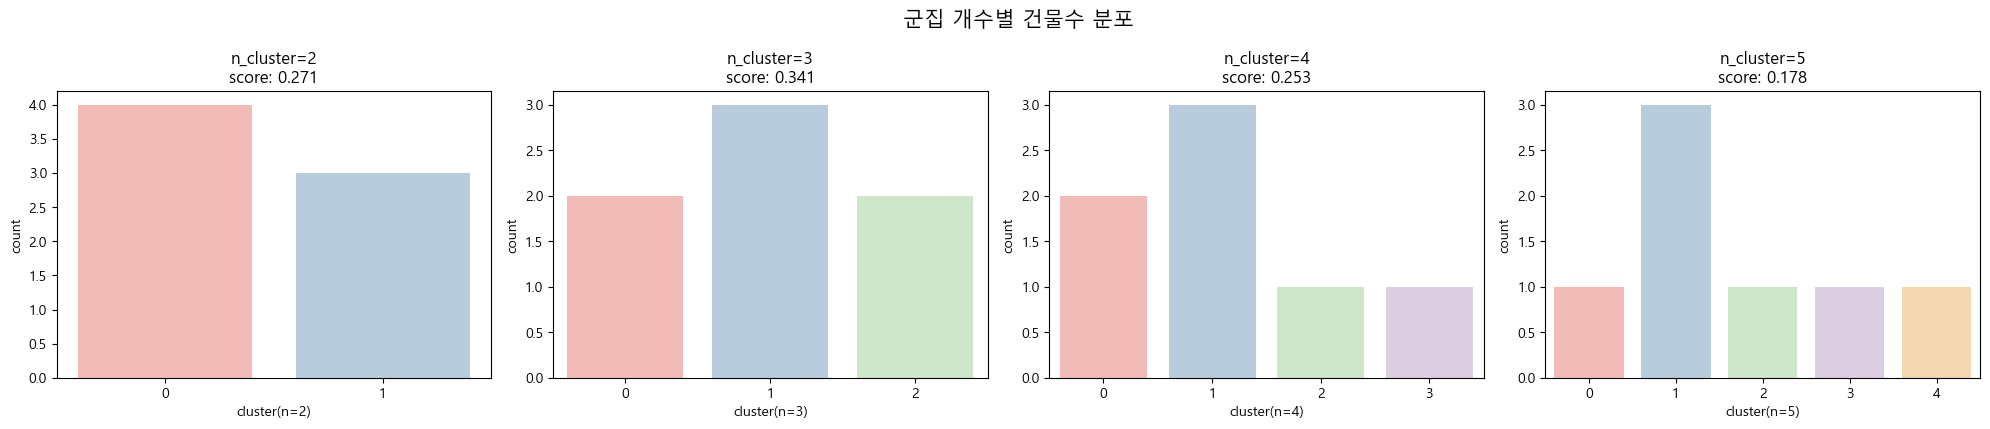

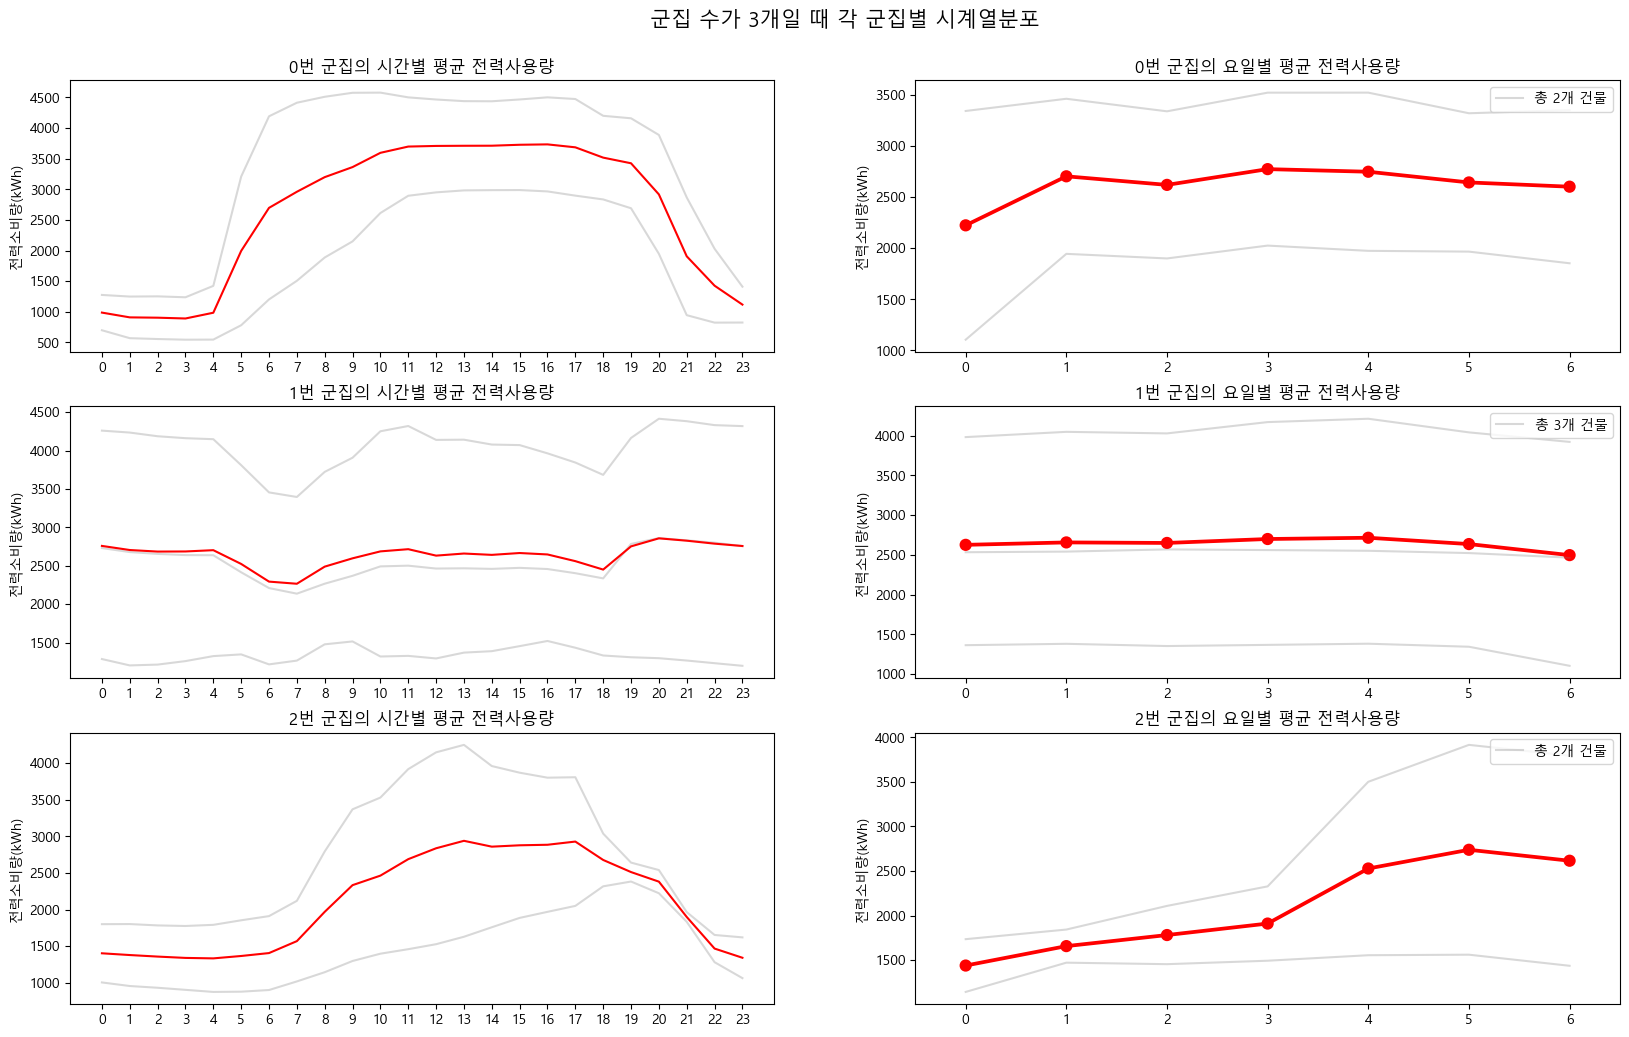

In [138]:
train_df, test_df = preprocess_df(train, test, 3)

In [140]:
train_df.groupby('cluster')['건물번호'].unique()

cluster
0    [16, 54]
Categories (7, int64): [3, 5, 8, 10, ...
1    [8, 10, 13]
Categories (7, int64): [3, 5, 8, 1...
2    [3, 5]
Categories (7, int64): [3, 5, 8, 10, 13...
Name: 건물번호, dtype: object

In [ ]:
def graph_by_cluster(cluster_num: str):
    building_nums = train_df.loc[train_df['cluster'] == cluster_num, '건물번호'].unique()
    fig, ax = plt.subplots(nrows=len(building_nums), figsize=(20, 3*len(building_nums)))
    for i, building_num in enumerate(building_nums):
        _ = ax[i].set_title(f'{building_num}')
        _ = sns.lineplot(data=train.loc[train['건물번호'] == building_num], y='전력소비량(kWh)', x='datehour', color='b', ax=ax[i])

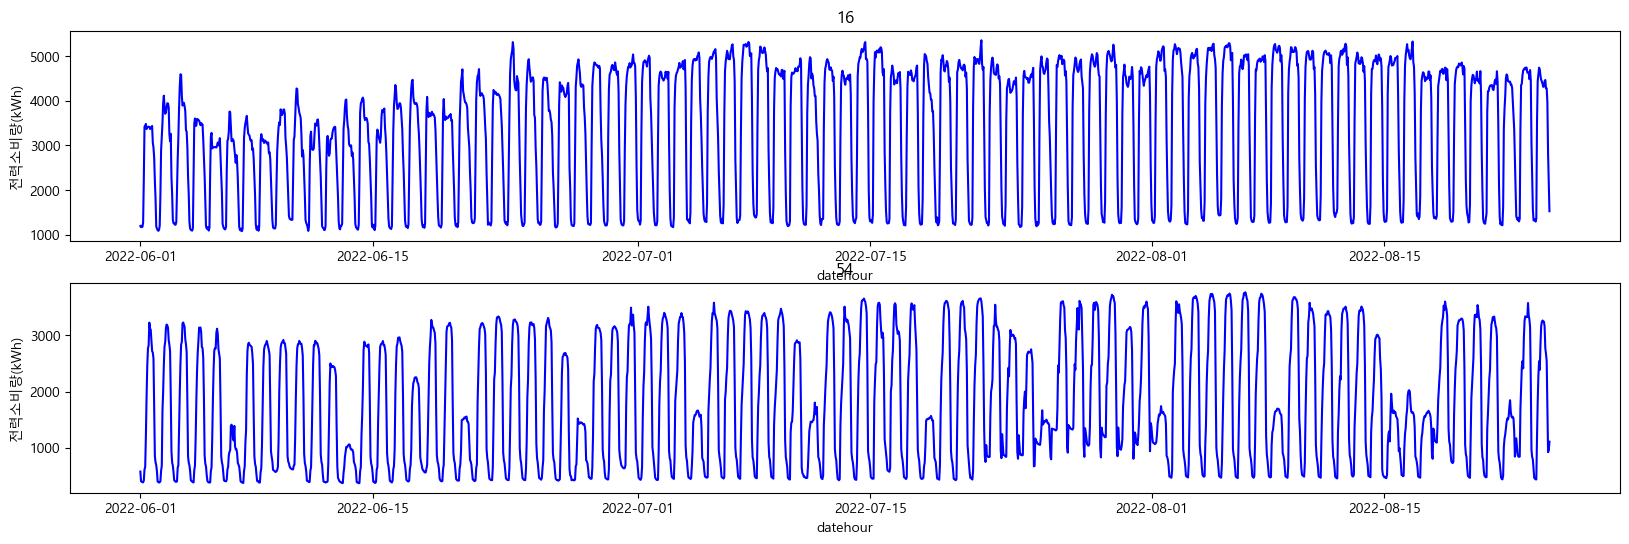

In [141]:
graph_by_cluster(cluster_num='0')